<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Regression" data-toc-modified-id="Regression-1">Regression</a></span><ul class="toc-item"><li><span><a href="#Import-and-Feature-Development" data-toc-modified-id="Import-and-Feature-Development-1.1">Import and Feature Development</a></span></li></ul></li><li><span><a href="#Regression" data-toc-modified-id="Regression-2">Regression</a></span></li><li><span><a href="#Regression" data-toc-modified-id="Regression-3">Regression</a></span><ul class="toc-item"><li><span><a href="#Define-Target-Variables" data-toc-modified-id="Define-Target-Variables-3.1">Define Target Variables</a></span></li><li><span><a href="#Hold-Out-Test-Set" data-toc-modified-id="Hold-Out-Test-Set-3.2">Hold Out Test Set</a></span></li></ul></li><li><span><a href="#Split-into-Train-and-Validate" data-toc-modified-id="Split-into-Train-and-Validate-4">Split into Train and Validate</a></span></li><li><span><a href="#Scale" data-toc-modified-id="Scale-5">Scale</a></span></li></ul></div>

## Regression

### Import and Feature Development

In [47]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)

import pickle
import features
import copy

from importlib import reload

import seaborn as sns
sns.set()

import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

%matplotlib inline

In [48]:
df_version = 'merged_10-06_23-26.pickle'
import_path = '../scraped/merged/' + df_version
with open(import_path, 'rb') as file:
    raw_df = pickle.load(file)
    
print('shape of raw df: ', raw_df.shape)
# print('number of empty columns: ', df[df.ep_total == 0].shape)

shape of raw df:  (4895, 15)


In [49]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4895 entries, 0 to 59
Data columns (total 15 columns):
title                4895 non-null object
chan_url             4895 non-null object
num_comments         4895 non-null int64
author               4895 non-null object
isExplicit           4895 non-null int64
sub_count            4895 non-null int64
play_count           4895 non-null int64
ch_feed-socials      4895 non-null object
ep_total             4895 non-null int64
recent_eps           4877 non-null object
hover_text_concat    4877 non-null object
chan_desc            4877 non-null object
cover_img_url        4877 non-null object
first_release        4895 non-null object
category             4895 non-null object
dtypes: int64(5), object(10)
memory usage: 611.9+ KB


In [50]:
raw_df.dropna(inplace=True)

# for EDA, mask entries where no episodes have been logged
df = raw_df[raw_df['ep_total'] != 0].copy()

df = features.build_features(df);

# list of all numeric columns suitable for regression
reg_cols = (['title','num_comments','isExplicit',
             'sub_count','play_count','ep_total',
             'recent_ep_spacing','lifetime_ep_freq', 'avg_ep_len',
             'twitter', 'twitter_followers','facebook','youtube','instagram'])

trim_df = df.loc[(df.play_count < 10000000.0) & (df.play_count > 50)]
trim_df.shape

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


(3997, 23)

In [51]:
pattern = re.compile('[\W_]+')
trim_df['category'] = trim_df.category.apply(lambda x: re.sub(r'\W+', '_', x))
trim_df.category.unique()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array(['Management_', 'Investing', 'Books', 'Fashion_Beauty', 'Courses',
       'Religion_Spirituality', 'Music', 'Non_profit', 'Standup',
       'Performing_Arts', 'Games_Hobbies', 'Comedy_Fiction', 'Comedy',
       'Design', 'Fiction', 'Society_Culture', 'Health', 'Education',
       'Science_Fiction', 'Self_Improvement', 'Careers',
       'Comedy_Interviews', 'Kids_Family', 'Animation_Manga',
       'News_Politics', 'Automotive', 'Technology', 'Visual_Arts',
       'Drama', 'Improv', 'Entrepreneurship', 'Food', 'Marketing',
       'Leisure', 'How_to', 'Business', 'Arts', 'TV_Film'], dtype=object)

In [60]:
dummies = pd.get_dummies(trim_df.category)
dummies.head(3)

,Animation_Manga,Arts,Automotive,Books,Business,Careers,Comedy,Comedy_Fiction,Comedy_Interviews,Courses,...,Non_profit,Performing_Arts,Religion_Spirituality,Science_Fiction,Self_Improvement,Society_Culture,Standup,TV_Film,Technology,Visual_Arts
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
for col in dummies.columns:
    trim_df['d_'+col] = dummies[col]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Merge in twitter stats:

In [62]:
with open('../social_metrics/twitter/channel_stats_by_name_oct7_9p.pickle', 'rb') as file:
    twitter_dict = pickle.load(file)
    
[twitter_dict[key] for key in list(twitter_dict.keys())[-5:]]

[{'title': 'Podcasting Simplified',
  'chan_url': 'https://castbox.fm/channel/Podcasting-Simplified-id1249099',
  'ch_feed-socials': ['https://twitter.com/podcastinsights',
   'https://www.facebook.com/podcastinsights',
   'https://www.instagram.com/podcastinsights',
   'https://www.podcastinsights.com/podcast/'],
  'screen_name': 'podcastinsights',
  'follower_count': 648},
 {'title': 'The Art of World Building: Creating Breakout Fantasy and Science Fiction Worlds In Stories and Gaming',
  'chan_url': 'https://castbox.fm/channel/The-Art-of-World-Building%3A-Creating-Breakout-Fantasy-and-Science-Fiction-Worlds-In-Stories-and-Gaming-id1351099',
  'ch_feed-socials': ['https://twitter.com/RandyEllefson',
   'https://randyellefson.com/'],
  'screen_name': 'RandyEllefson',
  'follower_count': 22425},
 {'title': 'Ask The Tech Guy (Video HD)',
  'chan_url': 'https://castbox.fm/channel/Ask-The-Tech-Guy-(Video-HD)-id2237855',
  'ch_feed-socials': ['https://twitter.com/TWiT',
   'https://www.fac

In [63]:
def pull_twitter_followers(row):
    title = row.title
    try:
        return twitter_dict[title]['follower_count']
    except:
        return 0

trim_df['twitter_followers'] = trim_df.apply(lambda row: pull_twitter_followers(row), axis=1)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [64]:
trim_df[trim_df.twitter == 1][reg_cols].sample(4)

,title,num_comments,isExplicit,sub_count,play_count,ep_total,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,twitter,twitter_followers,facebook,youtube,instagram
102,Judge John Hodgman,26,0,10961,350203,436,7.0,0.1,219.0,1,1083469,1,0,0
0,Pop Culture Happy Hour,41,0,67203,863311,300,3.3,0.3,216.0,1,36053,1,0,0
28,WSJ Your Money Briefing,7,0,11072,336435,332,1.2,0.8,215.9,1,16941694,1,0,0
8,2 Bears 1 Cave with Tom Segura & Bert Kreischer,121,0,21809,172974,8,15.9,0.1,217.2,1,3595,0,0,0


In [65]:
trim_df['chan_desc_len'] = trim_df.chan_desc.apply(lambda d: len(d))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
cols = ['title','num_comments','isExplicit',
             'sub_count','play_count','ep_total',
             'recent_ep_spacing','lifetime_ep_freq', 'avg_ep_len', 'chan_desc_len',
             'twitter', 'twitter_followers','facebook','youtube','instagram']

In [67]:
trim_df[cols].sample(3)

,title,num_comments,isExplicit,sub_count,play_count,ep_total,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,chan_desc_len,twitter,twitter_followers,facebook,youtube,instagram
52,"This Particular Album is Very, Very Important ...",0,1,47,250,21,42.0,0.0,217.4,452,0,0,0,0,0
38,Sleeping on the Job Podcast,2,1,9,147,42,8.3,0.1,216.6,135,0,0,0,0,0
24,A Scary Home Companion,0,0,30,228,44,7.0,0.1,219.5,259,0,0,0,0,0


In [68]:
trim_df['avg_ep_desc_len'] = trim_df.hover_text_concat.apply(lambda t: np.mean([len(t) for t in t.split('|')]))

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
trim_df['avg_ep_desc_len'].sample(3)

104      2.6
71    2252.9
29     699.7
Name: avg_ep_desc_len, dtype: float64

In [70]:
trim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3997 entries, 0 to 59
Data columns (total 64 columns):
title                      3997 non-null object
chan_url                   3997 non-null object
num_comments               3997 non-null int64
author                     3997 non-null object
isExplicit                 3997 non-null int64
sub_count                  3997 non-null int64
play_count                 3997 non-null int64
ch_feed-socials            3997 non-null object
ep_total                   3997 non-null int64
recent_eps                 3997 non-null object
hover_text_concat          3997 non-null object
chan_desc                  3997 non-null object
cover_img_url              3997 non-null object
first_release              3997 non-null object
category                   3997 non-null object
recent_ep_spacing          3990 non-null float64
lifetime_ep_freq           3997 non-null float64
avg_ep_len                 3986 non-null float64
chan_age                   3997 n

In [87]:
reg_df = trim_df.dropna()
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3979 entries, 0 to 59
Data columns (total 64 columns):
title                      3979 non-null object
chan_url                   3979 non-null object
num_comments               3979 non-null int64
author                     3979 non-null object
isExplicit                 3979 non-null int64
sub_count                  3979 non-null int64
play_count                 3979 non-null int64
ch_feed-socials            3979 non-null object
ep_total                   3979 non-null int64
recent_eps                 3979 non-null object
hover_text_concat          3979 non-null object
chan_desc                  3979 non-null object
cover_img_url              3979 non-null object
first_release              3979 non-null object
category                   3979 non-null object
recent_ep_spacing          3979 non-null float64
lifetime_ep_freq           3979 non-null float64
avg_ep_len                 3979 non-null float64
chan_age                   3979 n

## Regression

In [88]:
reg_df.corr()

,num_comments,isExplicit,sub_count,play_count,ep_total,recent_ep_spacing,lifetime_ep_freq,avg_ep_len,chan_age,twitter,...,d_Science_Fiction,d_Self_Improvement,d_Society_Culture,d_Standup,d_TV_Film,d_Technology,d_Visual_Arts,twitter_followers,chan_desc_len,avg_ep_desc_len
num_comments,1.0,0.1,0.5,0.7,0.1,-0.0,-0.0,0.0,0.0,0.3,...,-0.0,-0.0,0.1,-0.0,-0.0,0.0,-0.0,0.1,-0.0,-0.0
isExplicit,0.1,1.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,0.0,0.0,-0.0,0.1,0.1,-0.1,-0.0,-0.0,-0.0,-0.0
sub_count,0.5,0.0,1.0,0.9,0.1,-0.0,-0.0,0.0,0.1,0.3,...,-0.0,-0.0,0.1,-0.0,0.0,0.0,-0.0,0.1,-0.0,-0.0
play_count,0.7,0.0,0.9,1.0,0.2,-0.0,0.0,0.0,0.1,0.4,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.1,-0.0,-0.0
ep_total,0.1,-0.0,0.1,0.2,1.0,-0.1,0.1,-0.0,0.4,0.2,...,-0.1,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
recent_ep_spacing,-0.0,-0.0,-0.0,-0.0,-0.1,1.0,-0.1,-0.1,0.1,0.0,...,0.1,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
lifetime_ep_freq,-0.0,-0.0,-0.0,0.0,0.1,-0.1,1.0,-0.1,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0
avg_ep_len,0.0,-0.0,0.0,0.0,-0.0,-0.1,-0.1,1.0,0.0,-0.0,...,-0.1,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
chan_age,0.0,-0.0,0.1,0.1,0.4,0.1,-0.0,0.0,1.0,0.2,...,-0.0,-0.1,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
twitter,0.3,0.0,0.3,0.4,0.2,0.0,0.0,-0.0,0.2,1.0,...,-0.0,-0.1,0.0,-0.0,0.1,0.1,-0.1,0.1,-0.0,-0.0


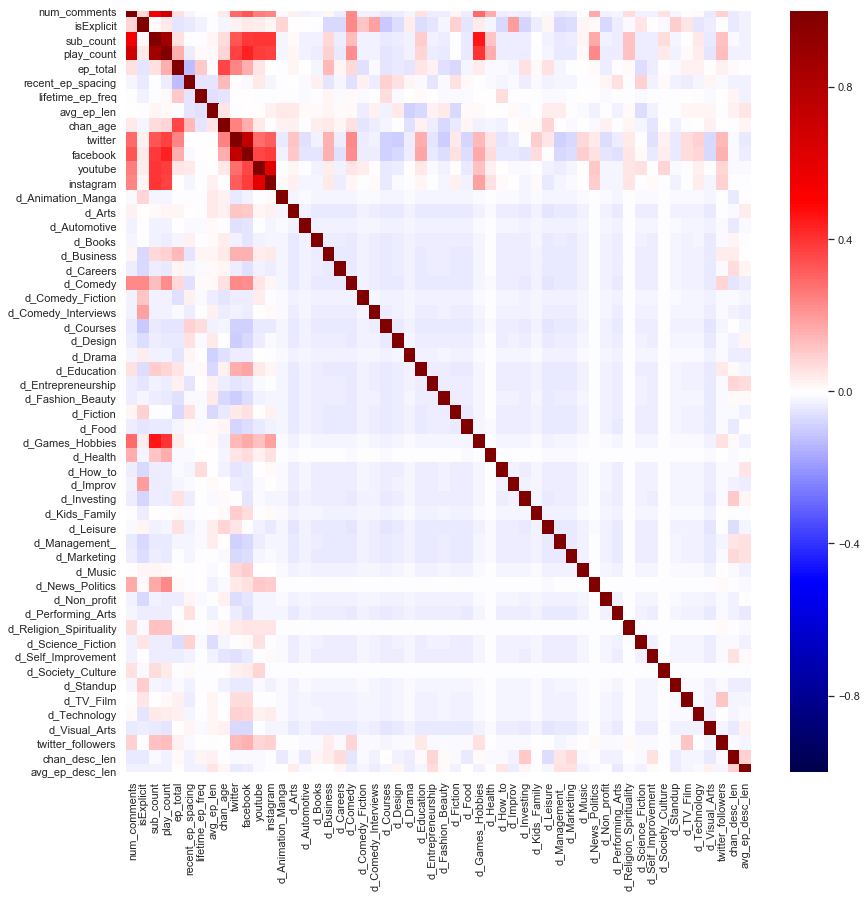

In [89]:
# example of a better corr matrix
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(trim_df.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

## Regression

In [90]:
reg_df.columns

Index(['title', 'chan_url', 'num_comments', 'author', 'isExplicit',
       'sub_count', 'play_count', 'ch_feed-socials', 'ep_total', 'recent_eps',
       'hover_text_concat', 'chan_desc', 'cover_img_url', 'first_release',
       'category', 'recent_ep_spacing', 'lifetime_ep_freq', 'avg_ep_len',
       'chan_age', 'twitter', 'facebook', 'youtube', 'instagram',
       'd_Animation_Manga', 'd_Arts', 'd_Automotive', 'd_Books', 'd_Business',
       'd_Careers', 'd_Comedy', 'd_Comedy_Fiction', 'd_Comedy_Interviews',
       'd_Courses', 'd_Design', 'd_Drama', 'd_Education', 'd_Entrepreneurship',
       'd_Fashion_Beauty', 'd_Fiction', 'd_Food', 'd_Games_Hobbies',
       'd_Health', 'd_How_to', 'd_Improv', 'd_Investing', 'd_Kids_Family',
       'd_Leisure', 'd_Management_', 'd_Marketing', 'd_Music',
       'd_News_Politics', 'd_Non_profit', 'd_Performing_Arts',
       'd_Religion_Spirituality', 'd_Science_Fiction', 'd_Self_Improvement',
       'd_Society_Culture', 'd_Standup', 'd_TV_Film', 'd_

In [91]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
newdf = reg_df.select_dtypes(include=numerics).sample(1)
newdf.columns

Index(['num_comments', 'isExplicit', 'sub_count', 'play_count', 'ep_total',
       'recent_ep_spacing', 'lifetime_ep_freq', 'avg_ep_len', 'chan_age',
       'twitter', 'facebook', 'youtube', 'instagram', 'd_Animation_Manga',
       'd_Arts', 'd_Automotive', 'd_Books', 'd_Business', 'd_Careers',
       'd_Comedy', 'd_Comedy_Fiction', 'd_Comedy_Interviews', 'd_Courses',
       'd_Design', 'd_Drama', 'd_Education', 'd_Entrepreneurship',
       'd_Fashion_Beauty', 'd_Fiction', 'd_Food', 'd_Games_Hobbies',
       'd_Health', 'd_How_to', 'd_Improv', 'd_Investing', 'd_Kids_Family',
       'd_Leisure', 'd_Management_', 'd_Marketing', 'd_Music',
       'd_News_Politics', 'd_Non_profit', 'd_Performing_Arts',
       'd_Religion_Spirituality', 'd_Science_Fiction', 'd_Self_Improvement',
       'd_Society_Culture', 'd_Standup', 'd_TV_Film', 'd_Technology',
       'd_Visual_Arts', 'twitter_followers', 'chan_desc_len',
       'avg_ep_desc_len'],
      dtype='object')

### Define Target Variables

In [137]:
reg_cols = ['isExplicit', 'ep_total',
       'recent_ep_spacing', 'lifetime_ep_freq', 'avg_ep_len', 'chan_age',
       'twitter', 'facebook', 'youtube', 'instagram', 'twitter_followers',
       'chan_desc_len', 'avg_ep_desc_len']

# sub_count is currently withheld from regression

In [138]:
# predictors
X = reg_df[reg_cols]

# target
y = reg_df.play_count

### Hold Out Test Set

In [139]:
X_non_test, X_test, y_non_test, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

## Split into Train and Validate

In [140]:
X_train, X_val, y_train, y_val = train_test_split(X_non_test, y_non_test, test_size=0.2,random_state=42)

## Scale

In [147]:
simple_lr = LinearRegression()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Ridge model
ridge_reg = Ridge(alpha = 10000)

In [151]:
#validate

simple_lr.fit(X_train, y_train)
print(f'Linear Regression val R^2: {simple_lr.score(X_val, y_val):.3f}')

ridge_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {ridge_reg.score(X_val_scaled, y_val):.3f}')

Linear Regression val R^2: 0.210
Ridge Regression val R^2: 0.126


In [152]:
for z in zip(reg_cols, simple_lr.coef_):
    print(z)

('isExplicit', 53571.92905572213)
('ep_total', 272.62548141261584)
('recent_ep_spacing', -142.8022797997745)
('lifetime_ep_freq', 534.3628850585626)
('avg_ep_len', 9203.831502619305)
('chan_age', -4.3987354276371144)
('twitter', 109097.5429490956)
('facebook', 284535.6579429611)
('youtube', 543015.3478299641)
('instagram', 413424.3494500465)
('twitter_followers', 0.06628983987857087)
('chan_desc_len', -24.78834710866105)
('avg_ep_desc_len', -10.262315429072903)


In [153]:
for z in zip(reg_cols, ridge_reg.coef_):
    print(z)

('isExplicit', 6675.033448693853)
('ep_total', 16739.469719169807)
('recent_ep_spacing', -2619.6930704603024)
('lifetime_ep_freq', 819.2159885431349)
('avg_ep_len', 1999.693907582763)
('chan_age', 6767.906997524298)
('twitter', 30366.384413835087)
('facebook', 36337.06231306007)
('youtube', 34273.01957933915)
('instagram', 31961.714172125543)
('twitter_followers', 16583.695226768174)
('chan_desc_len', -2461.9019320864486)
('avg_ep_desc_len', -3650.7218873724364)


In [136]:
simple_lr.fit(X,y)
print(f'Linear Regression test R^2: {simple_lr.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.490
